In [305]:
from datetime import datetime, timedelta, date
import csv
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

import os
import xgboost as xgb
from sklearn import model_selection, preprocessing
color = sns.color_palette()

In [306]:
def num2log(arr):
    return np.log(arr + 1)

In [333]:
fulldt = pd.read_csv('Full_Monthly.csv',index_col=0)
df = fulldt.copy()

In [334]:
df.shape

(35064, 81)

In [308]:
df['Date'] = pd.to_datetime(df['Date'])

### Distribution of OAS

In [309]:
df.describe()["OAS"]

count    34999.000000
mean       138.259805
std        103.342547
min      -1503.125000
25%         84.694456
50%        114.509722
75%        159.228902
max       2459.297562
Name: OAS, dtype: float64

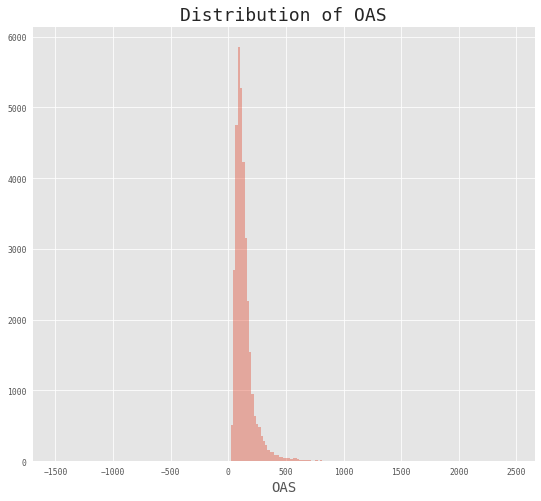

In [310]:
plt.figure(figsize=(9,8))
sns.distplot(df.OAS.dropna(), bins=200, kde=False)
plt.xlabel('OAS', fontsize=14)
plt.title('Distribution of OAS', fontsize = 18)
plt.show()

### Missing Value

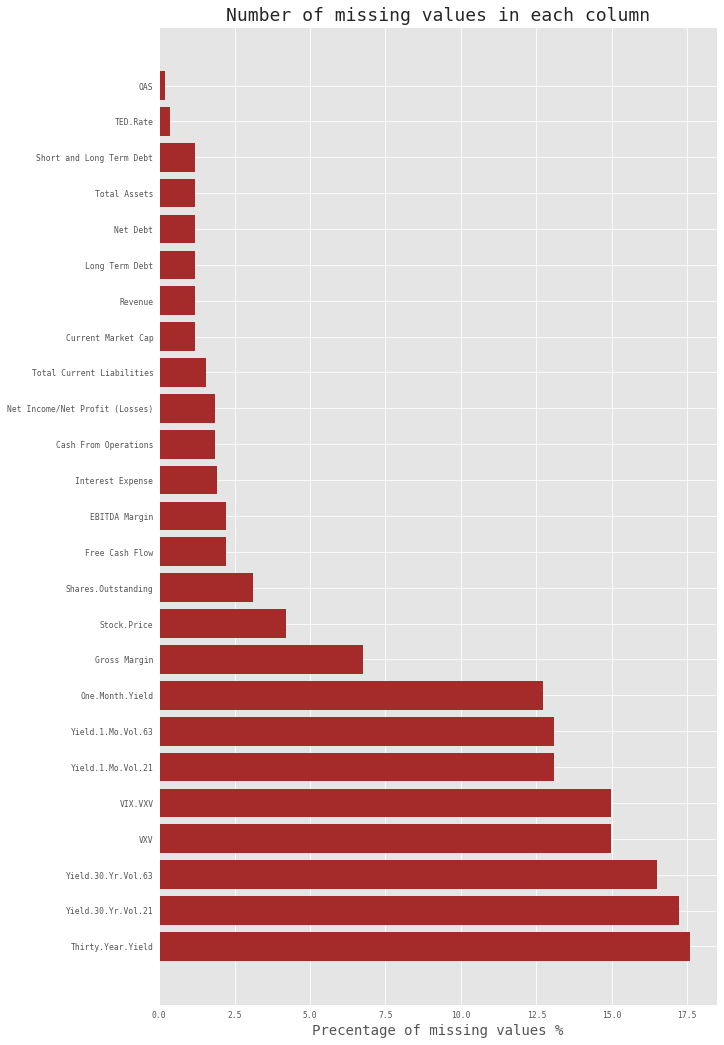

In [311]:
missing = df.isnull().sum(0).reset_index()
missing.columns = ['column', 'count']
missing = missing.sort_values(by = 'count', ascending = False).loc[missing['count'] > 0]
missing['percentage'] = missing['count'] / float(df.shape[0]) * 100
ind = np.arange(missing.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, missing.percentage.values, color='brown')
ax.set_yticks(ind)
ax.set_yticklabels(missing.column.values, rotation='horizontal')
ax.set_xlabel("Precentage of missing values %", fontsize = 14)
ax.set_title("Number of missing values in each column", fontsize = 18)
plt.show()


### Remove variables with more than 10% missing values

In [312]:
df.drop(["One.Month.Yield","Yield.1.Mo.Vol.63","Yield.1.Mo.Vol.21",
                 "VIX.VXV","VXV","Yield.30.Yr.Vol.63","Yield.30.Yr.Vol.21","Thirty.Year.Yield"], axis=1, inplace=True)

In [313]:
df.head()

,Date,Ticker,Sector,Industry,Cash From Operations,Current Market Cap,EBITDA Margin,Free Cash Flow,Gross Margin,Interest Expense,...,Yield.7.Yr.Vol.21,Yield.7.Yr.Vol.63,Yield.10.Yr.Vol.21,Yield.10.Yr.Vol.63,Yield.20.Yr.Vol.21,Yield.20.Yr.Vol.63,Total,OAS,Shiller.PE.Ratio,VIX.Value
1,1998-07-01,BAX,"Consumer, Non-cyclical",Healthcare-Products,146.000,15118.3532,25.5814,17.000,46.0888,39.000,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.83215,72.402903,38.26,24.799999
2,1998-07-01,VOD,Communications,Telecommunications,NaN,256921.1418,NaN,NaN,NaN,NaN,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.83215,78.340585,38.26,24.799999
3,1998-07-01,PXD,Energy,Oil&Gas,91.369,2398.8883,45.2357,-56.929,23.5375,41.017,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.83215,147.188061,38.26,24.799999
4,1998-07-01,KMI,Energy,Pipelines,453.000,36519.0472,27.3650,-10.000,34.1947,297.000,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.83215,113.533557,38.26,24.799999
5,1998-07-01,AZN,"Consumer, Non-cyclical",Pharmaceuticals,311.000,82119.0000,28.0482,-203.000,69.4947,33.000,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.83215,60.176544,38.26,24.799999


### Aggregate and get average OAS

In [314]:
df.drop(["Industry","Ticker","Sector"],1)

,Date,Cash From Operations,Current Market Cap,EBITDA Margin,Free Cash Flow,Gross Margin,Interest Expense,Long Term Debt,Net Debt,Net Income/Net Profit (Losses),...,Yield.7.Yr.Vol.21,Yield.7.Yr.Vol.63,Yield.10.Yr.Vol.21,Yield.10.Yr.Vol.63,Yield.20.Yr.Vol.21,Yield.20.Yr.Vol.63,Total,OAS,Shiller.PE.Ratio,VIX.Value
1,1998-07-01,146.000,15118.3532,25.5814,17.000,46.0888,39.000,2964.0000,2851.0000,63.000,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.832150,72.402903,38.26,24.799999
2,1998-07-01,NaN,256921.1418,NaN,NaN,NaN,NaN,32100.3530,41880.2630,NaN,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.832150,78.340585,38.26,24.799999
3,1998-07-01,91.369,2398.8883,45.2357,-56.929,23.5375,41.017,2139.0840,2097.1630,-32.809,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.832150,147.188061,38.26,24.799999
4,1998-07-01,453.000,36519.0472,27.3650,-10.000,34.1947,297.000,31053.0000,33677.0000,-126.000,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.832150,113.533557,38.26,24.799999
5,1998-07-01,311.000,82119.0000,28.0482,-203.000,69.4947,33.000,739.0000,-2171.0000,694.000,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.832150,60.176544,38.26,24.799999
6,1998-07-01,182.400,10565.1002,14.5929,121.500,58.8478,44.300,1640.4000,2051.3000,91.800,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.832150,49.443165,38.26,24.799999
7,1998-07-01,9.000,7058.9059,14.1655,-37.000,23.7494,59.000,2706.0000,2852.0000,93.000,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.832150,88.350714,38.26,24.799999
8,1998-07-01,320.400,NaN,32.9183,243.300,35.9330,27.900,1584.1000,1212.3000,45.400,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.832150,59.259209,38.26,24.799999
9,1998-07-01,1347.000,135819.3801,5.8650,481.000,21.1778,185.000,9934.0000,9775.0000,1034.000,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.832150,44.136821,38.26,24.799999
10,1998-07-01,182.000,11280.9306,37.5348,-63.000,NaN,127.000,7539.0000,7418.0000,187.000,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.832150,81.829028,38.26,24.799999


In [315]:
df = df.groupby("Date").mean()
df

,Cash From Operations,Current Market Cap,EBITDA Margin,Free Cash Flow,Gross Margin,Interest Expense,Long Term Debt,Net Debt,Net Income/Net Profit (Losses),Revenue,...,Yield.7.Yr.Vol.21,Yield.7.Yr.Vol.63,Yield.10.Yr.Vol.21,Yield.10.Yr.Vol.63,Yield.20.Yr.Vol.21,Yield.20.Yr.Vol.63,Total,OAS,Shiller.PE.Ratio,VIX.Value
Date,,,,,,,,,,,,,,,,,,,,,
1998-07-01,560.879261,33091.673206,21.644107,243.562767,40.488601,81.962443,5252.251600,5203.273315,293.244815,4512.970416,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.832150,70.368364,38.26,24.799999
1998-08-01,573.548623,31598.860595,22.502815,258.401161,40.408875,81.245486,5307.006491,5163.340371,288.503727,4429.171976,...,0.039194,0.095914,0.037136,0.096231,0.055283,0.115589,83.081350,74.131415,35.42,44.279999
1998-09-01,589.894220,30614.847820,23.191160,269.107182,40.310613,81.074264,5353.043279,5164.683810,283.489639,4412.036325,...,0.140402,0.124384,0.121475,0.102958,0.085732,0.091965,117.118731,105.403491,33.53,40.950001
1998-10-01,616.854567,30890.017034,23.219817,273.292202,40.078959,82.536892,5416.575862,5282.406371,279.901445,4564.796226,...,0.204319,0.358805,0.183421,0.313982,0.078516,0.187200,108.267015,101.326841,33.77,28.049999
1998-11-01,647.833927,32244.898930,23.091801,264.481316,39.883587,84.861000,5423.751760,5466.988861,273.801704,4845.287717,...,0.164861,0.413384,0.168819,0.374456,0.168363,0.194161,137.672554,120.098424,37.37,26.010000
1998-12-01,669.003153,34256.741630,22.736251,246.484498,39.697905,87.587917,5418.972986,5650.348252,269.010932,5152.998969,...,0.122317,0.223619,0.084120,0.206856,0.071528,0.132408,117.358650,109.680580,38.82,24.420000
1999-01-01,644.335009,35166.951363,22.212884,220.975560,39.614413,88.361886,5329.143764,5586.376072,179.844142,5185.634411,...,0.109818,0.177612,0.086630,0.165375,0.083023,0.135264,118.502610,112.288629,40.57,26.250000
1999-02-01,591.455607,35871.729774,22.256030,195.392461,39.567175,88.325367,5348.853217,5425.903878,203.636804,5062.903322,...,0.069543,0.123154,0.073118,0.104639,0.068435,0.088144,111.971817,107.744256,40.40,27.879999
1999-03-01,527.799730,35924.900552,22.513311,178.917232,39.633491,87.126424,5383.689981,5159.992569,230.317886,4799.738079,...,0.191184,0.217588,0.176186,0.181723,0.144930,0.153856,105.652739,102.236282,41.35,23.260000


### Correlation

In [316]:
dfcor = df
dfcor = dfcor.reset_index()
dfcor.drop(["Date"], axis=1, inplace=True)
dfcor

,Cash From Operations,Current Market Cap,EBITDA Margin,Free Cash Flow,Gross Margin,Interest Expense,Long Term Debt,Net Debt,Net Income/Net Profit (Losses),Revenue,...,Yield.7.Yr.Vol.21,Yield.7.Yr.Vol.63,Yield.10.Yr.Vol.21,Yield.10.Yr.Vol.63,Yield.20.Yr.Vol.21,Yield.20.Yr.Vol.63,Total,OAS,Shiller.PE.Ratio,VIX.Value
0,560.879261,33091.673206,21.644107,243.562767,40.488601,81.962443,5252.251600,5203.273315,293.244815,4512.970416,...,0.057499,0.095478,0.062579,0.100107,0.067771,0.117695,76.832150,70.368364,38.26,24.799999
1,573.548623,31598.860595,22.502815,258.401161,40.408875,81.245486,5307.006491,5163.340371,288.503727,4429.171976,...,0.039194,0.095914,0.037136,0.096231,0.055283,0.115589,83.081350,74.131415,35.42,44.279999
2,589.894220,30614.847820,23.191160,269.107182,40.310613,81.074264,5353.043279,5164.683810,283.489639,4412.036325,...,0.140402,0.124384,0.121475,0.102958,0.085732,0.091965,117.118731,105.403491,33.53,40.950001
3,616.854567,30890.017034,23.219817,273.292202,40.078959,82.536892,5416.575862,5282.406371,279.901445,4564.796226,...,0.204319,0.358805,0.183421,0.313982,0.078516,0.187200,108.267015,101.326841,33.77,28.049999
4,647.833927,32244.898930,23.091801,264.481316,39.883587,84.861000,5423.751760,5466.988861,273.801704,4845.287717,...,0.164861,0.413384,0.168819,0.374456,0.168363,0.194161,137.672554,120.098424,37.37,26.010000
5,669.003153,34256.741630,22.736251,246.484498,39.697905,87.587917,5418.972986,5650.348252,269.010932,5152.998969,...,0.122317,0.223619,0.084120,0.206856,0.071528,0.132408,117.358650,109.680580,38.82,24.420000
6,644.335009,35166.951363,22.212884,220.975560,39.614413,88.361886,5329.143764,5586.376072,179.844142,5185.634411,...,0.109818,0.177612,0.086630,0.165375,0.083023,0.135264,118.502610,112.288629,40.57,26.250000
7,591.455607,35871.729774,22.256030,195.392461,39.567175,88.325367,5348.853217,5425.903878,203.636804,5062.903322,...,0.069543,0.123154,0.073118,0.104639,0.068435,0.088144,111.971817,107.744256,40.40,27.879999
8,527.799730,35924.900552,22.513311,178.917232,39.633491,87.126424,5383.689981,5159.992569,230.317886,4799.738079,...,0.191184,0.217588,0.176186,0.181723,0.144930,0.153856,105.652739,102.236282,41.35,23.260000
9,264.511490,36666.654902,22.780073,-950.236620,40.003042,170.056128,14355.596839,8667.967216,89.445359,17360.981586,...,0.071694,0.263221,0.082396,0.242567,0.060289,0.197162,101.540019,97.518967,42.70,25.070000


In [317]:
for f in dfcor.columns:
    if dfcor[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df[f].values)) 
        dfcor[f] = lbl.transform(list(dfcor[f].values))
dtype_df = dfcor.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,float64,69


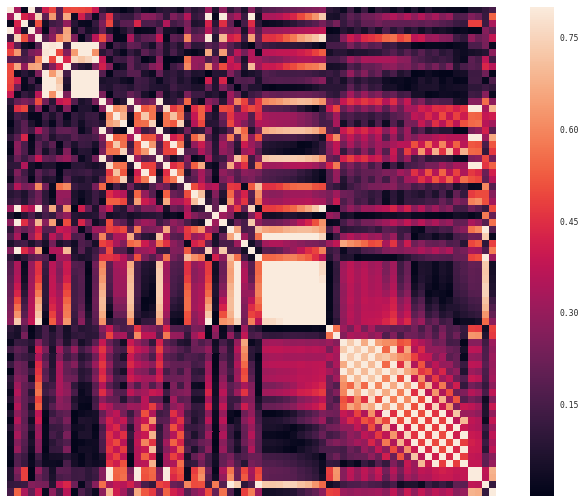

In [318]:
corrmat = dfcor.corr(method='pearson')
# plot absolute values
corrmat = np.abs(corrmat)
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, xticklabels = False, yticklabels = False)

* Many of these features are highly correlated.

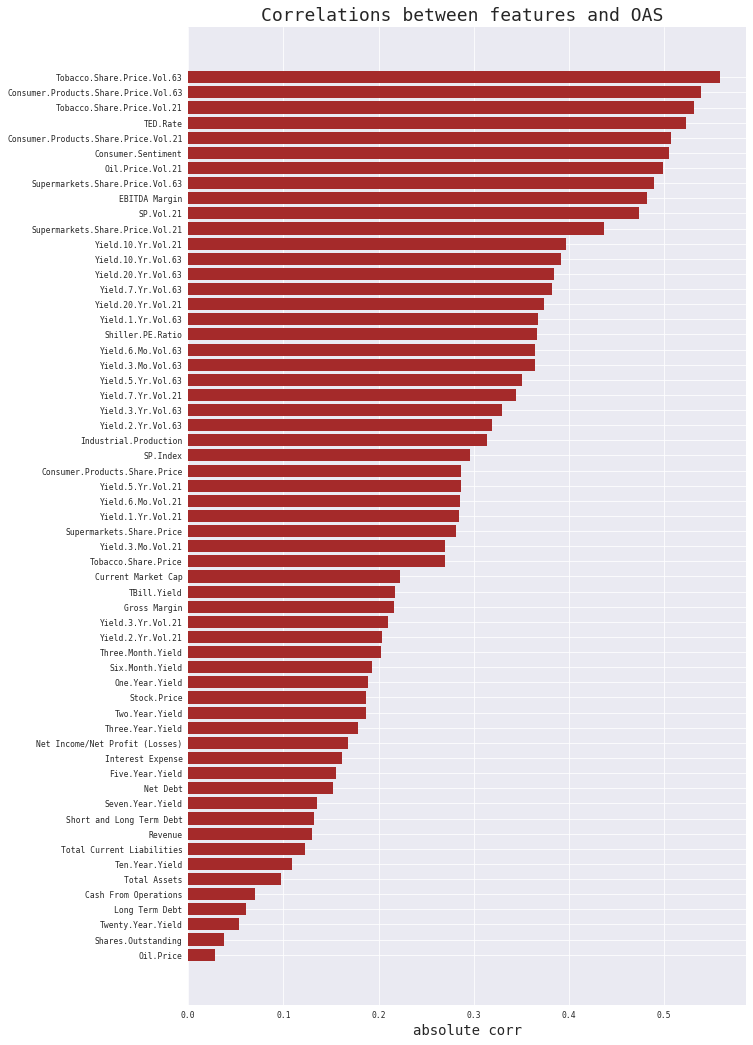

In [319]:
remain_num = 60
corr_target = corrmat['OAS'].reset_index()
corr_target.columns = ['feature','abs_corr']
corr_target = corr_target.sort_values(by = 'abs_corr', ascending = True)[:remain_num].loc[corr_target['abs_corr'] >0.01]
ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, corr_target.abs_corr.values, color='brown')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("absolute corr", fontsize = 14)
ax.set_title("Correlations between features and OAS ", fontsize = 18)
plt.show()

In [320]:
corr_target_f = list(corr_target.feature.values)

In [321]:
len(corr_target_f)

59

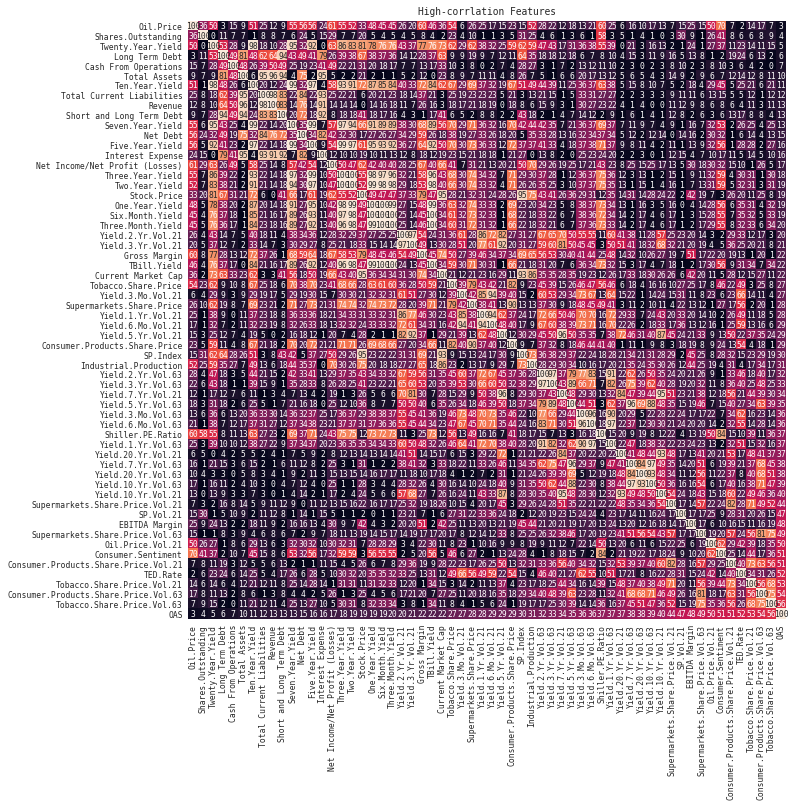

In [322]:
corr_target_f2 = corr_target_f
corr_target_f2.append('OAS')
high_corr = dfcor[corr_target_f2].corr(method='pearson')
high_corr = np.abs(high_corr)*100
f, ax = plt.subplots(figsize=(11, 11))
sns.heatmap(high_corr, cbar=False, annot=True, square=True, fmt='.0f', 
            annot_kws={'size': 8})
plt.title('High-corrlation Features')
plt.show()

In [323]:
### Remove duplicated variables that have at least 90 correlations

In [324]:
remove_list = ['Long Term Debt','Cash From Operations'
               "Twenty.Year.Yield",
               "Yield.1.Yr.Vol.21","Three.Year.Yield","One.Year.Yield","Six.Month.Yield","Yield.2.Yr.Vol.21",
               "Yield.2.Yr.Vol.63","Yield.20.Yr.Vol.21","Yield.10.Yr.Vol.63","Yield.3.Mo.Vol.63",
               "Total Current Liabilities","Revenue","Short and Long Term Debt","Total Assets",
               "Twenty.Year.Yield","Ten.Year.Yield","Five.Year.Yield","Two.Year.Yield"
]
corr_target_f = [x for x in corr_target_f if x not in remove_list]

In [325]:
len(corr_target_f)

42

In [326]:
dfset = df[corr_target_f]
dfset

,Oil.Price,Shares.Outstanding,Cash From Operations,Seven.Year.Yield,Net Debt,Interest Expense,Net Income/Net Profit (Losses),Stock.Price,Three.Month.Yield,Yield.3.Yr.Vol.21,...,EBITDA Margin,Supermarkets.Share.Price.Vol.63,Oil.Price.Vol.21,Consumer.Sentiment,Consumer.Products.Share.Price.Vol.21,TED.Rate,Tobacco.Share.Price.Vol.21,Consumer.Products.Share.Price.Vol.63,Tobacco.Share.Price.Vol.63,OAS
Date,,,,,,,,,,,,,,,,,,,,,
1998-07-01,14.37,906.569147,560.879261,5.50,5203.273315,81.962443,293.244815,28.050665,5.09,0.051760,...,21.644107,0.461285,1.150393,105.2,0.646761,0.76,0.390679,0.873875,0.566191,70.368364
1998-08-01,13.70,909.095431,573.548623,5.51,5163.340371,81.245486,288.503727,24.737926,5.13,0.020366,...,22.502815,0.406915,0.353816,104.4,1.069966,0.71,0.189031,1.084814,0.306932,74.131415
1998-09-01,13.73,898.254524,589.894220,5.06,5164.683810,81.074264,283.489639,26.538458,4.92,0.168965,...,23.191160,0.417468,0.336289,100.9,0.553583,0.80,0.445259,1.366517,0.436715,105.403491
1998-10-01,15.43,906.318735,616.854567,4.26,5282.406371,82.536892,279.901445,28.649997,4.23,0.170046,...,23.219817,0.682632,0.767747,97.4,0.683481,1.18,0.793815,0.897754,0.626822,101.326841
1998-11-01,14.36,905.961912,647.833927,4.63,5466.988861,84.861000,273.801704,29.775166,4.54,0.098990,...,23.091801,1.212584,0.627651,102.7,1.468868,0.96,1.018096,1.195129,0.974477,120.098424
1998-12-01,11.13,908.284196,669.003153,4.63,5650.348252,87.587917,269.010932,31.171630,4.49,0.141514,...,22.736251,1.730169,0.991206,100.5,0.757816,0.90,0.603377,1.501035,1.089402,109.680580
1999-01-01,12.34,886.070038,644.335009,4.75,5586.376072,88.361886,179.844142,30.860147,4.49,0.125672,...,22.212884,1.686557,0.421576,103.9,0.657146,0.68,0.533492,1.493883,1.096885,112.288629
1999-02-01,12.37,885.588311,591.455607,4.82,5425.903878,88.325367,203.636804,30.435373,4.53,0.060875,...,22.256030,1.117972,0.449710,108.1,0.499862,0.55,0.495523,0.921073,0.879581,107.744256
1999-03-01,12.24,886.552170,527.799730,5.49,5159.992569,87.126424,230.317886,31.774840,4.71,0.175069,...,22.513311,0.794167,0.388552,105.7,1.113736,0.45,0.738947,1.310319,0.766651,102.236282


### Feature selection by xgb

In [110]:
### Impute NA

In [329]:
def imputena(x):
    return dfset[x].interpolate(method='linear', inplace=True)

In [335]:
fulldt = fulldt.dropna()

In [336]:
train_y = fulldt.OAS.values
train_X = fulldt.drop(["Ticker","OAS","Date","Industry","Ticker","Sector"], axis=1)
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
remain_num = 99

[21:53:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=10
[21:53:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=10
[21:53:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 598 extra nodes, 0 pruned nodes, max_depth=10
[21:53:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[21:53:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[21:53:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=10
[21:53:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=10
[21:53:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=10
[21:53:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 p

[21:53:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 816 extra nodes, 0 pruned nodes, max_depth=10
[21:53:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 918 extra nodes, 0 pruned nodes, max_depth=10
[21:53:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 880 extra nodes, 0 pruned nodes, max_depth=10
[21:53:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 730 extra nodes, 0 pruned nodes, max_depth=10
[21:54:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 938 extra nodes, 0 pruned nodes, max_depth=10
[21:54:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 874 extra nodes, 0 pruned nodes, max_depth=10
[21:54:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 636 extra nodes, 0 pruned nodes, max_depth=10
[21:54:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 886 extra nodes, 0 pruned nodes, max_depth=10
[21:54:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 862 extra nodes, 0 p

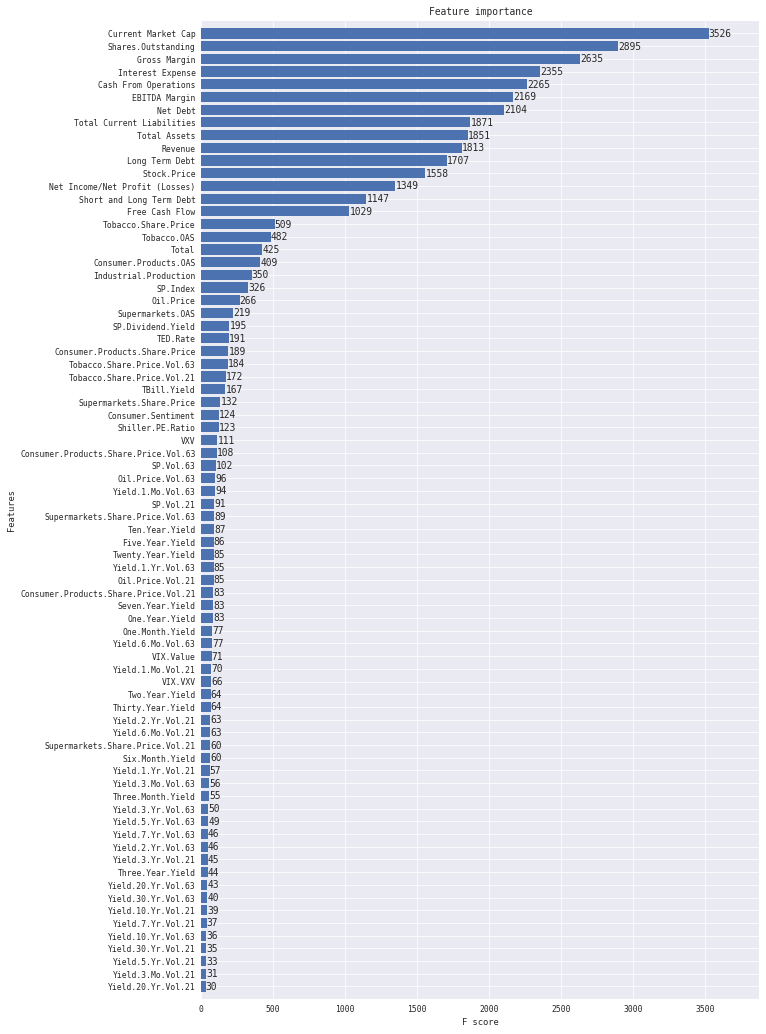

In [337]:
fig, ax = plt.subplots(figsize=(10,18))
xgb.plot_importance(model, max_num_features=remain_num, height=0.8, ax=ax)
plt.show()

In [338]:
importance = model.get_score(importance_type='weight')
tuples = sorted([(k, importance[k]) for k in importance], key=lambda x: x[1], reverse=True)[:remain_num]
xgb_imp_f = [x[0] for x in tuples]

In [339]:
model

In [340]:
total_f = list(set(xgb_imp_f) | set(corr_target_f))
common_f = list(set(xgb_imp_f) & set(corr_target_f))
xgb_top_f = xgb_imp_f[:10]
corr_top_f = corr_target_f[:10]
print('there are {} features chosen in total'.format(len(total_f)))
print('there are {} features chosen in common'.format(len(common_f)))

there are 77 features chosen in total
there are 41 features chosen in common


In [341]:
len(xgb_imp_f)

76

In [342]:
dfset = df[common_f]

In [343]:
dfset.shape

(35064, 41)

In [346]:
dfset.to_csv("features.csv")